In [2]:
options(mc.cores = parallel::detectCores())
library(rethinking)

In [3]:
library(dagitty)

QUESTION 1

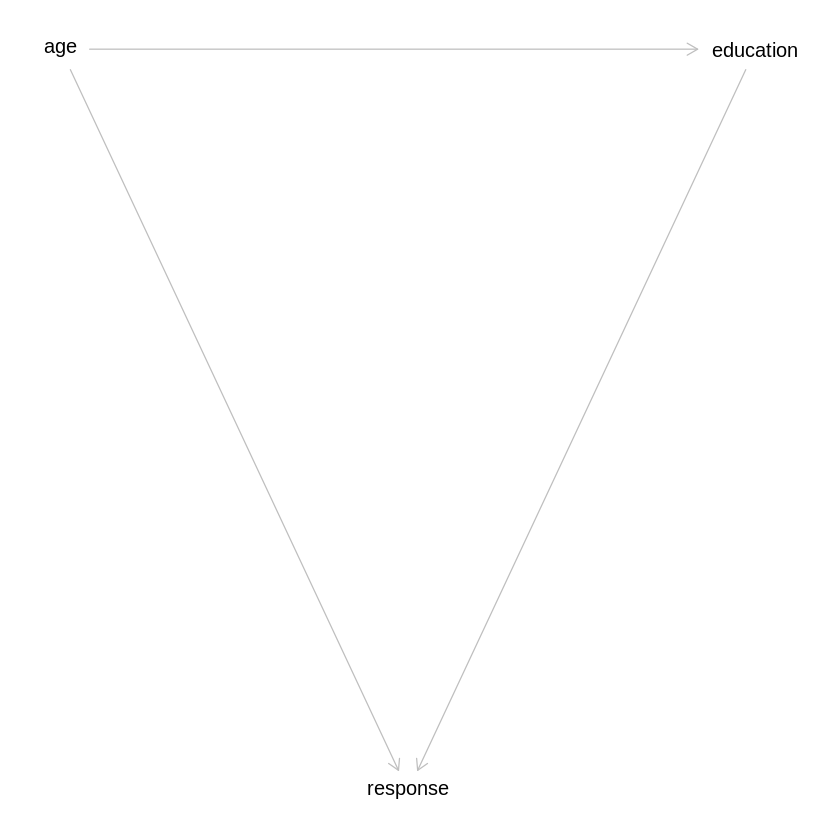

In [4]:
# response, education, age

trolley_dag <- dagitty(
                    "dag {
                            age -> education -> response
                            age -> response
                        }"
                    )

coordinates( trolley_dag ) <- list( x=c(age=0,education=1,response=0.5) , y=c(age=0,education=0,response=0.5) ) 

plot( trolley_dag )

Age could confound the relationship between education and response, because age could influence response, but age also 'causes' education.

There is thus a backdoor path from education to response through age, if we do not condition on age.  So let's condition on age.

In [22]:
library(rethinking)
library(gtools)
data(Trolley)
d <- Trolley


Attaching package: ‘gtools’

The following object is masked from ‘package:rethinking’:

    logit



In [23]:
edu_levels <- c( 6 , 1 , 8 , 4 , 7 , 2 , 5 , 3 )
d$edu_new <- edu_levels[ d$edu ]

In [24]:
dat <- list(
            R = d$response ,
            action = d$action,
            intention = d$intention,
            contact = d$contact,
            E = as.integer( d$edu_new ), # edu_new as an index
            age = standardize(d$age),
            alpha = rep(2,7)        # delta prior
        )

In [25]:
m <- ulam(   # Note, need library(gtools) to get this to run. otherwise there is an error parsing to Stan.
        alist(
            R ~ dordlogit( phi , kappa ),
            phi <- bE*sum( delta_j[1:E] ) + bAge * age + bA*action + bI*intention + bC*contact,
            kappa ~ normal( 0 , 1.5 ),
            c(bAge, bA,bI,bC,bE) ~ normal( 0 , 1 ),
            vector[8]: delta_j <<- append_row( 0 , delta ),
            simplex[7]: delta ~ dirichlet( alpha )
        ),
        data=dat , chains=3 , cores=3 )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


In [30]:
precis( m , depth=2 , omit="kappa" )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bE,0.23236017,0.10971234,0.06396736,0.37081774,392.6421,1.0055980
bC,-0.96082527,0.04864656,-1.03595610,-0.88528215,1429.1105,0.9992243
bI,-0.72086629,0.03772449,-0.78142546,-0.66040117,1958.4533,0.9984805
bA,-0.70884673,0.03944476,-0.77299824,-0.64529548,1877.7222,0.9997345
bAge,-0.09934678,0.02025671,-0.13061955,-0.06606583,1318.8480,0.9986897
delta[1],0.11341560,0.07395928,0.02419210,0.24557171,1389.4516,0.9981593
delta[2],0.11936998,0.07362977,0.02620516,0.25617368,2312.2479,0.9991010
delta[3],0.08575175,0.06105030,0.01589752,0.20806046,1826.7084,0.9999164
delta[4],0.06438390,0.05258213,0.01211893,0.16178683,759.8412,1.0033077


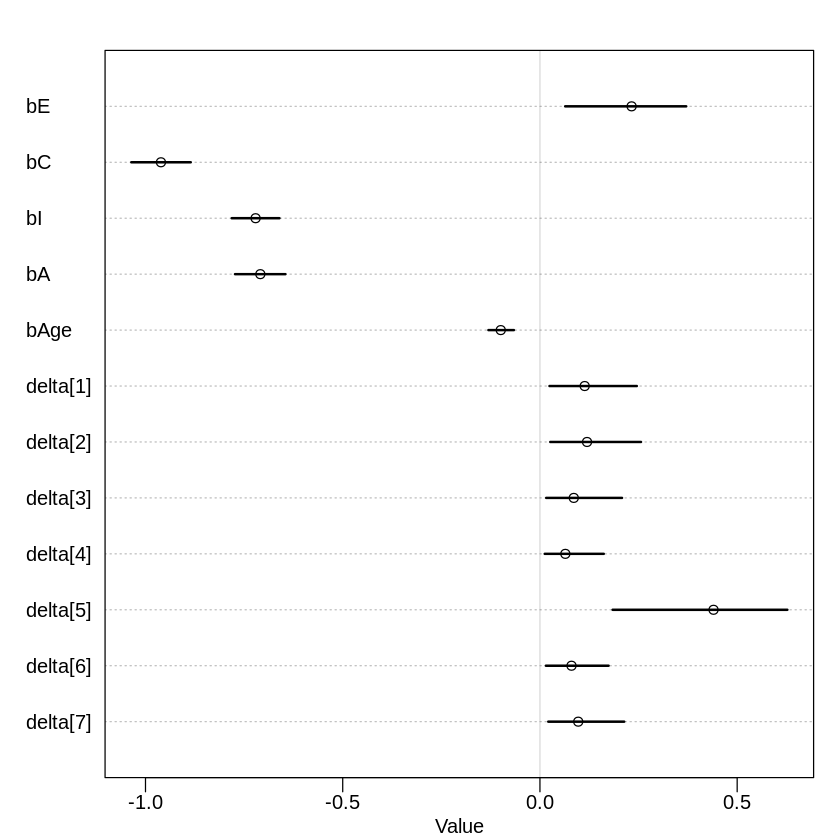

In [31]:
plot(precis( m , depth=2 , omit="kappa" ))

Compare the coefficients here to those found on page 402 of the 2nd edition of the book, after R code box 12.35.  The sign of the education coefficient bE has completely changed from an 89% credible intervale (-0.57, -0.05) to (+0.06, +0.37) instead.  So now it appears that people with more education tend to be more permissive.  The effect is generally stronger than age, but not as strong as the coefficients bC, bI and bA.

bAge is estimated to be negative and significantly different from 0, in a narrow range.  Note that, although the other coefficients (bC, bI, bA) haven't changed compard to the book, the delta[] values have.

So clearly, there was previously some backdoor paths confounding the estimation.

From the solutions:
"You may recall from the chapter that education has a negative effect in the model
without age. Now that we include age, education has a positive influence (with some
overlap with zero). So age has indeed soaked up some of the previous influence
assigned to education. The back-door may be real."

Note that the n_eff wasn't too large for some coefficients, so let's just check the traceplots:

Waiting to draw page 2 of 2


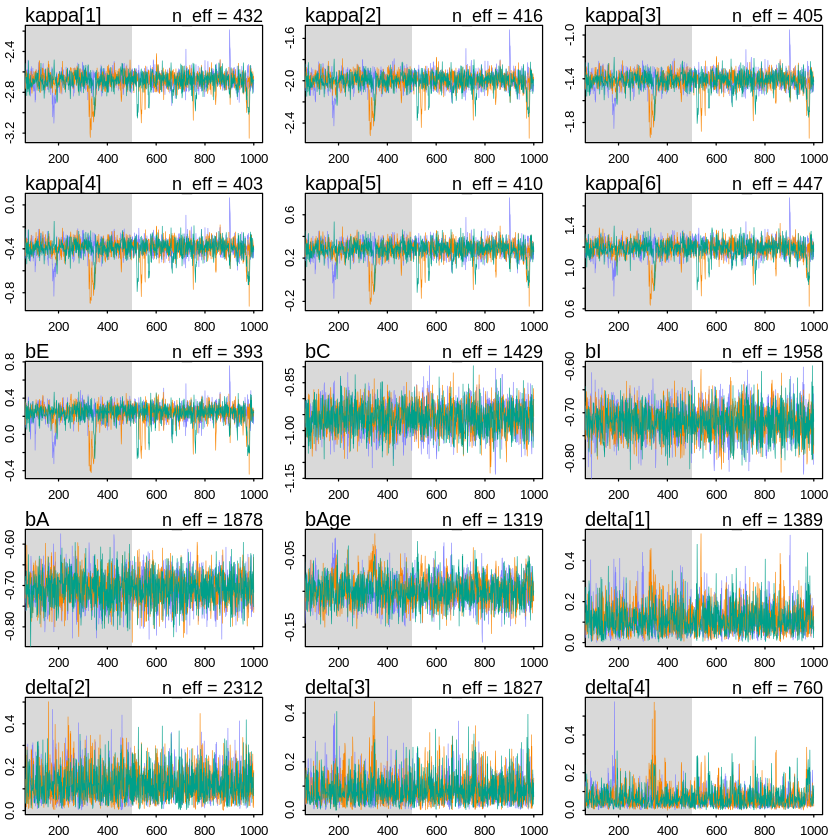

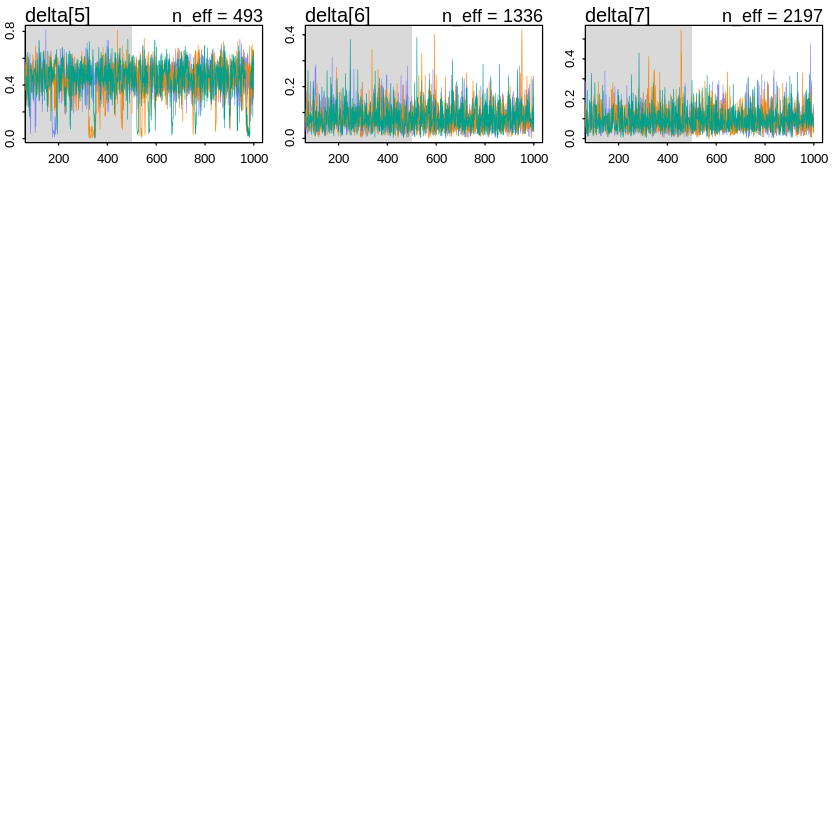

In [36]:
traceplot(m)

The traceplots don't look great for education, the kappas nor the deltas.

QUESTION 2

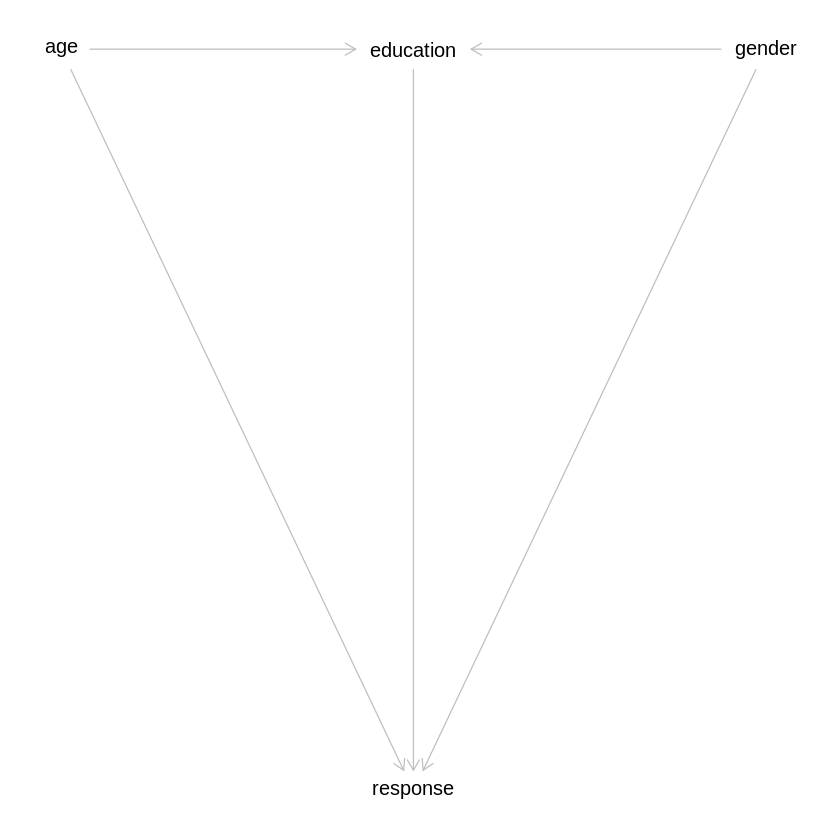

In [44]:
# response, education, age

trolley_dag2 <- dagitty(
                    "dag {
                            age -> education -> response
                            age -> response
                            response <- gender -> education
                        }"
                    )

coordinates( trolley_dag2 ) <- list( x=c(age=0,education=0.5,response=0.5, gender=1) , y=c(age=0,education=0,response=1, gender=0) ) 

plot( trolley_dag2 )

Education is now a collider between age and gender.  This means that by conditioning on education, we open the backdoor path from gender to age.  However, this is not relevant, given that what we are interested is the direct causal impact of education on response.

(Also, as we have conditioned response on age, this removes the backdoor path from gender to response via education and age.  And because we have conditioned on education, there is no backdoor path from gender to response via education either.)

However, looking at the DAG we can see the symmetry - just like age, gender also is a confound to estimating the direct causal impact of education on response.  Thus, just like we conditioned on age to solve the age confound, we need to condition on gender to solve this gender confound.

We can check we are write by asking the computer to do the analysis:

In [47]:
adjustmentSets( trolley_dag2 , exposure="education" , outcome="response" , effect="total" )

 { age, gender }

As expected, this shows that both age and gender must be conditioned on, to get the correct causal impact of education on response.

We now run a model that includes gender as an index variable.

In [54]:
d$gid <- ifelse(d$male==0, 1L, 2L)

dat <- list(
            R = d$response ,
            action = d$action,
            intention = d$intention,
            contact = d$contact,
            E = as.integer( d$edu_new ), # edu_new as an index
            age = standardize(d$age),
            gid = d$gid,
            alpha = rep(2,7)        # delta prior
        )

In [60]:
#library(gtools)

m2 <- ulam(   # Note, need library(gtools) to get this to run. otherwise there is an error parsing to Stan.
        alist(
            R ~ dordlogit( phi , kappa ),
            phi <- bE[gid]*sum( delta_j[1:E] ) + bAge[gid] * age + bA[gid]*action + bI[gid]*intention + bC[gid]*contact,
            kappa ~ normal( 0 , 1.5 ),
            bAge[gid] ~ normal( 0 , 1 ),
            bA[gid] ~ normal( 0 , 1 ),
            bI[gid] ~ normal( 0 , 1 ),
            bC[gid] ~ normal( 0 , 1 ),
            bE[gid] ~ normal( 0 , 1 ),
            vector[8]: delta_j <<- append_row( 0 , delta ),
            simplex[7]: delta ~ dirichlet( alpha )
        ),
        data=dat , chains=3 , cores=3 )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


In [61]:
precis( m2 , depth=2 , omit="kappa" )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bAge[1],0.001815951,0.02913174,-0.044951959,0.04792971,1751.0648,0.9997552
bAge[2],-0.128119830,0.02809418,-0.172312580,-0.08369808,1227.9780,0.9989946
bA[1],-0.569326914,0.05769737,-0.661428274,-0.48025690,1554.1838,1.0006600
bA[2],-0.831355584,0.05573440,-0.919778238,-0.74329838,1301.7188,0.9986588
bI[1],-0.666051885,0.05665372,-0.757817398,-0.57227539,1460.8262,1.0013774
bI[2],-0.772954221,0.05381284,-0.858376611,-0.68620241,2328.0635,0.9993978
bC[1],-0.784292391,0.07373543,-0.899960034,-0.66303287,2039.9865,1.0002777
bC[2],-1.125412849,0.06695017,-1.230863538,-1.01794535,1156.4916,1.0000489
bE[1],-0.705918190,0.13136668,-0.913180437,-0.48708875,486.0472,1.0003644


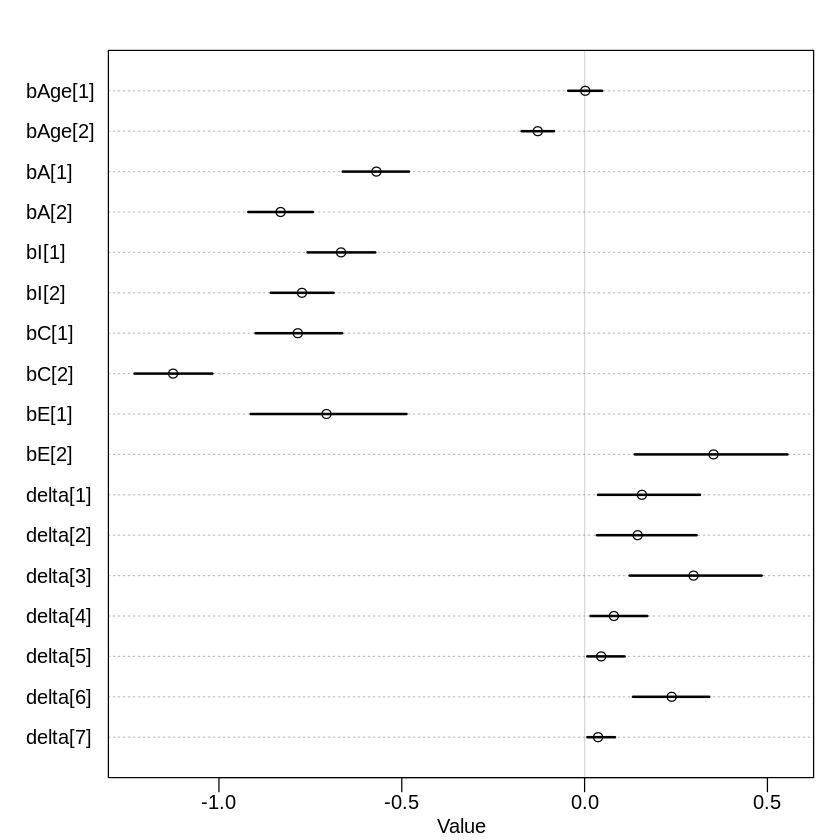

In [62]:
plot(precis( m2 , depth=2 , omit="kappa" ))

Waiting to draw page 2 of 2


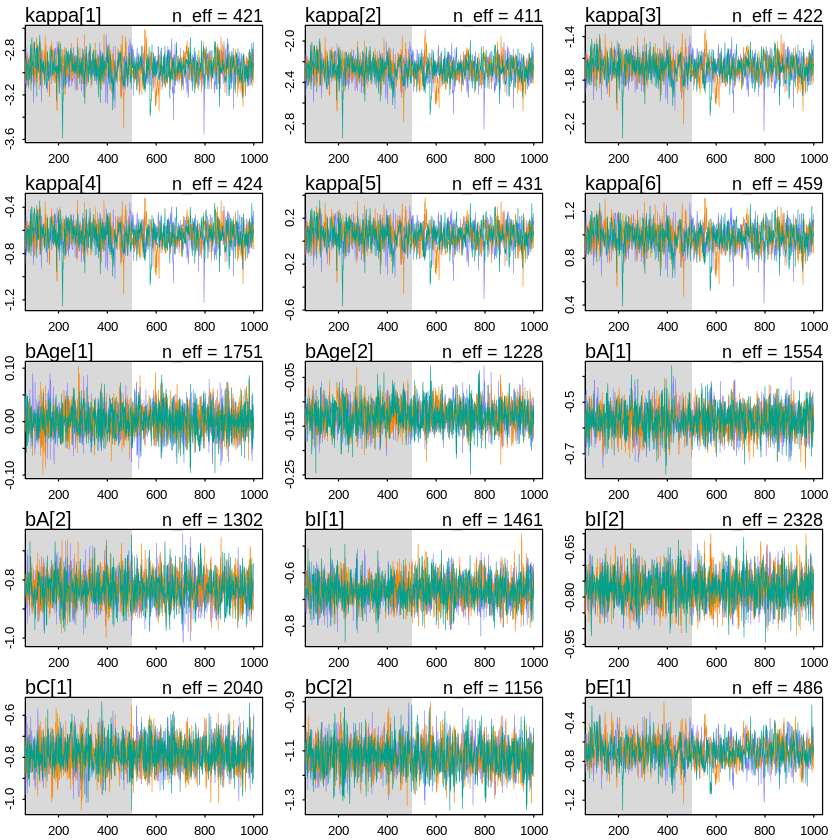

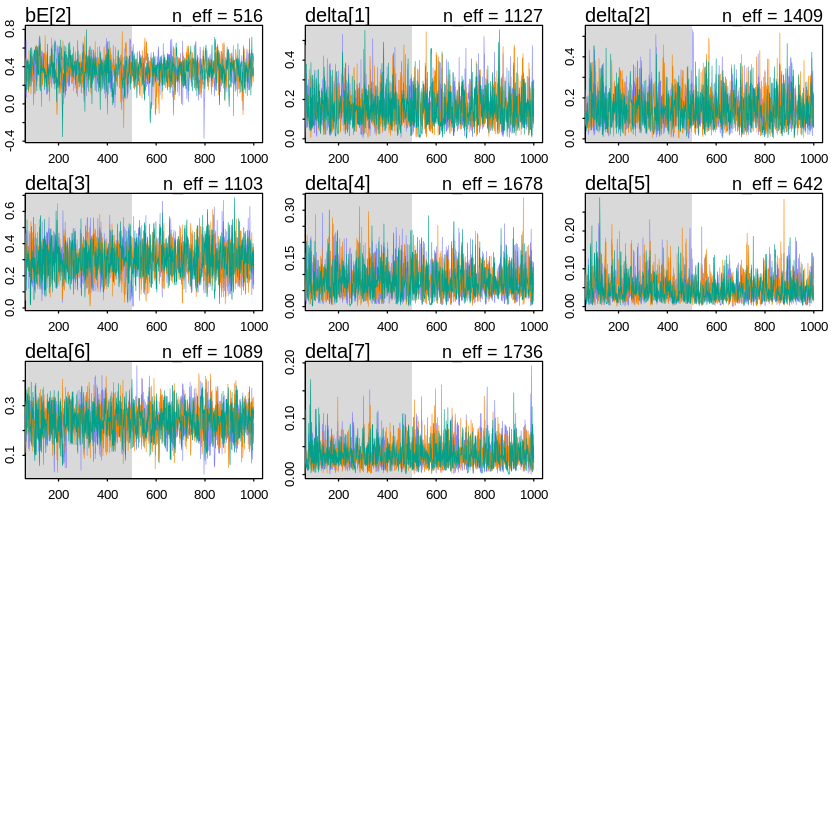

In [63]:
traceplot(m2)

The model above uses gender specific indices for all coefficients, modelling the INTERACTION between each predictor and gender.  This is different to what McElreath does in the solutions - he uses a dummy variable to represent gender (Females).  This corresponds to us introducing an gender specific intercept term a[gid] in the link function, rather than making all the other coefficients gender specific.  So we do this below instead (be warned, this simulation took over half an hour on Ana's old work Dell laptop).

In [64]:
#library(gtools)
# Be warned, this simulation took over half an hour on Ana's old work Dell laptop).
m3 <- ulam(   # Note, need library(gtools) to get this to run. otherwise there is an error parsing to Stan.
        alist(
            R ~ dordlogit( phi , kappa ),
            phi <- a[gid] + bE*sum( delta_j[1:E] ) + bAge * age + bA*action + bI*intention + bC*contact,
            kappa ~ normal( 0 , 1.5 ),
            c(bAge, bA,bI,bC,bE) ~ normal( 0 , 1 ),
            a[gid] ~ normal( 0 , 1 ),
            vector[8]: delta_j <<- append_row( 0 , delta ),
            simplex[7]: delta ~ dirichlet( alpha )
        ),
        data=dat , chains=3 , cores=3 )

Cautionary note:
Variable alpha contains only integers but is not type 'integer'. If you intend it as an index variable, you should as.integer() it before passing to ulam.


Higher value of gender-specific intercept parameter 'a' means more approval.

In [66]:
precis( m3 , depth=2 , omit="kappa" )

,mean,sd,5.5%,94.5%,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bE,-0.01293497,0.17461777,-0.28615263,0.2530168,424.7704,1.0052838
bC,-0.97109756,0.05042879,-1.05128736,-0.8897461,1019.2449,1.0034230
bI,-0.72584593,0.03775661,-0.78677695,-0.6685025,1665.5050,1.0020975
bA,-0.71292476,0.04119065,-0.77998099,-0.6494858,966.7144,1.0030206
bAge,-0.06543503,0.02264381,-0.10203270,-0.0296030,763.3060,1.0026475
a[1],0.30109950,0.44968212,-0.40794232,1.0101148,618.8547,1.0019814
a[2],0.86332413,0.45070986,0.15473097,1.5759415,621.9796,1.0017151
delta[1],0.15407684,0.09987372,0.03088247,0.3417527,1376.6386,0.9988477
delta[2],0.14188783,0.08910381,0.03086685,0.3079102,1874.7930,0.9989169


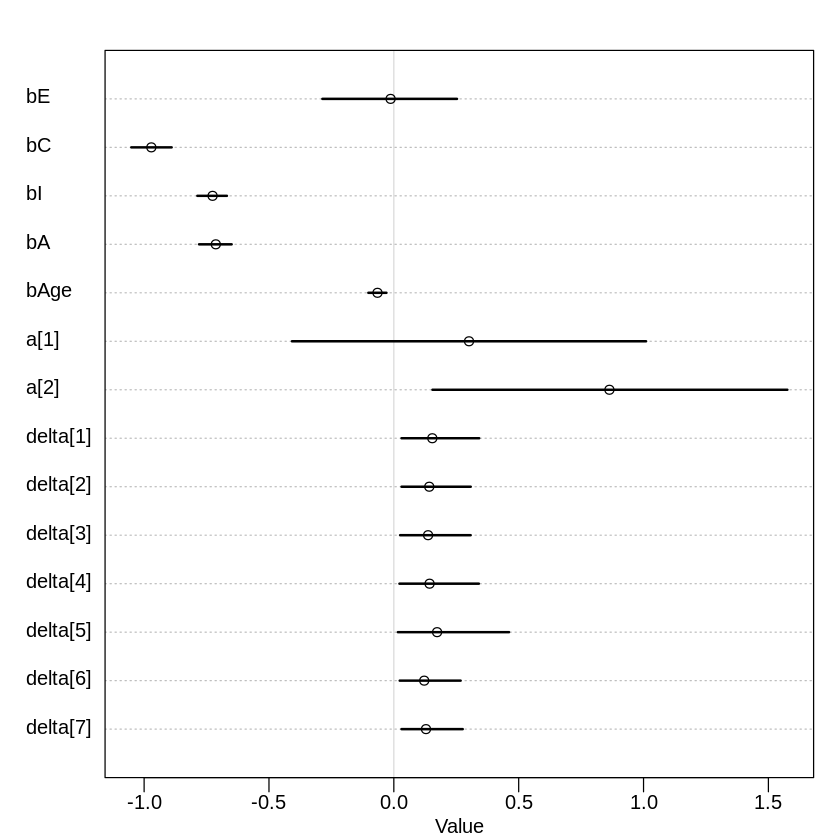

In [67]:
plot(precis( m3 , depth=2 , omit="kappa" ))

These results are similar to those in McElreath in that now bE is very much centered on 0, and bAge is small and negative.  Also the bI, bA and bC have the same signs, although differ in magnitude.  

McElreath has bF (coefficient of dummy variable for Females) as mean of -0.56 and 89% credible interval (-0.62, -0.5).

In order to obtain this type of estimate, we need to look at the contrast between a[1] and a[2], with index 1 representing females, so we need to calculate a[1]-a[2]:

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
post.diff_fm,-0.5622246,0.03638371,-0.618033,-0.5032727,▁▁▁▂▅▇▇▅▂▁▁▁▁▁


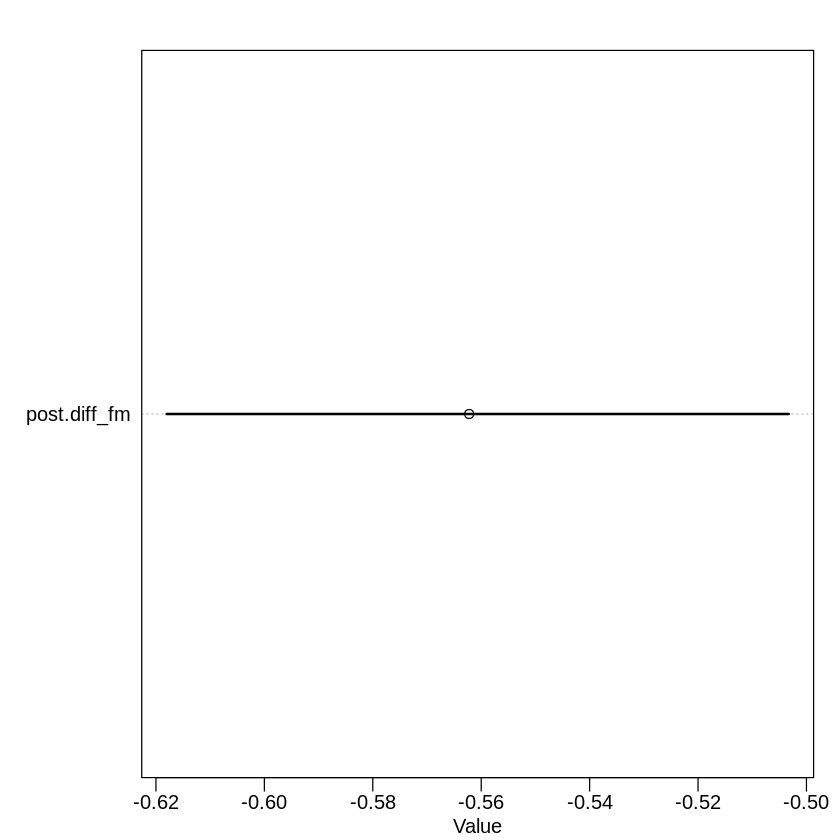

In [69]:
post <- extract.samples(m3)
post$diff_fm <- post$a[,1] - post$a[,2]
precis( post$diff_fm )
plot(precis( post$diff_fm ))

Therefore, we match McElreath's analysis using our own index version.

From the solutions, despite McElreath using a dummy variable for Female rather than index gender variables like I do:

"Age is still negative (and weak), while education is right near zero and straddles
both sides. Gender seems to have accounted for all of the previous influenced as-
signed to education. It looks like female respondents gave lower average responses—
indicating less approval.
It would be worth figuring out how gender is associated with education in this
sample. It could be true for example that some education levels under-sampled men
or women, and this leads to another kind of confound. Consider for example if older
men are less likely to respond, so the sample becomes increasingly female with age.
Then education level will also be increasingly female with age. Since the sample is
not a representative sample of the population, there are probably some biases of this
sort."

Waiting to draw page 2 of 2


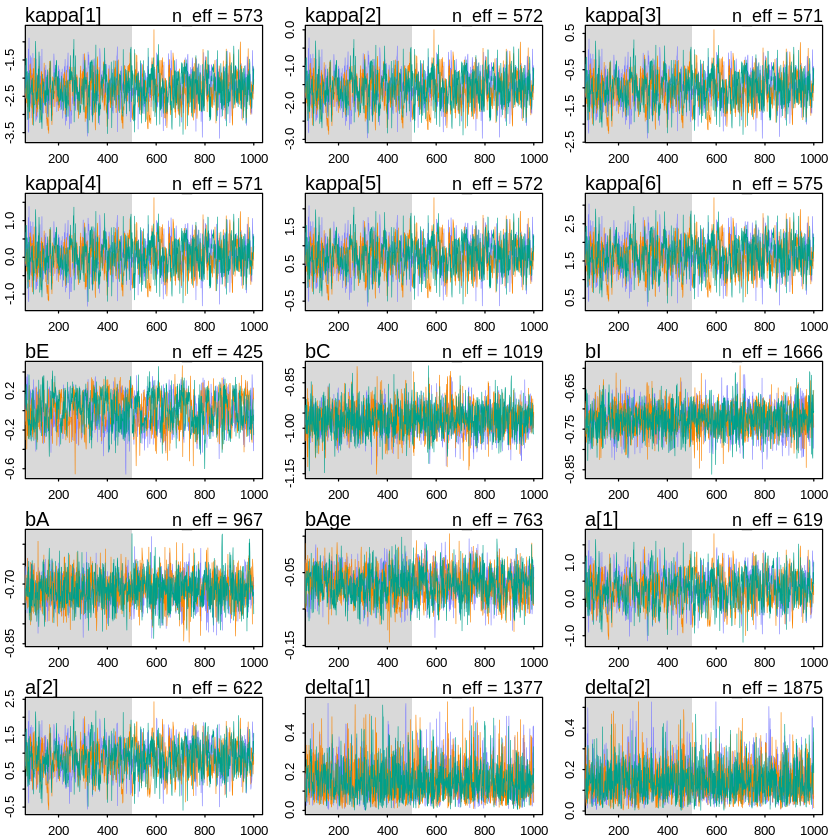

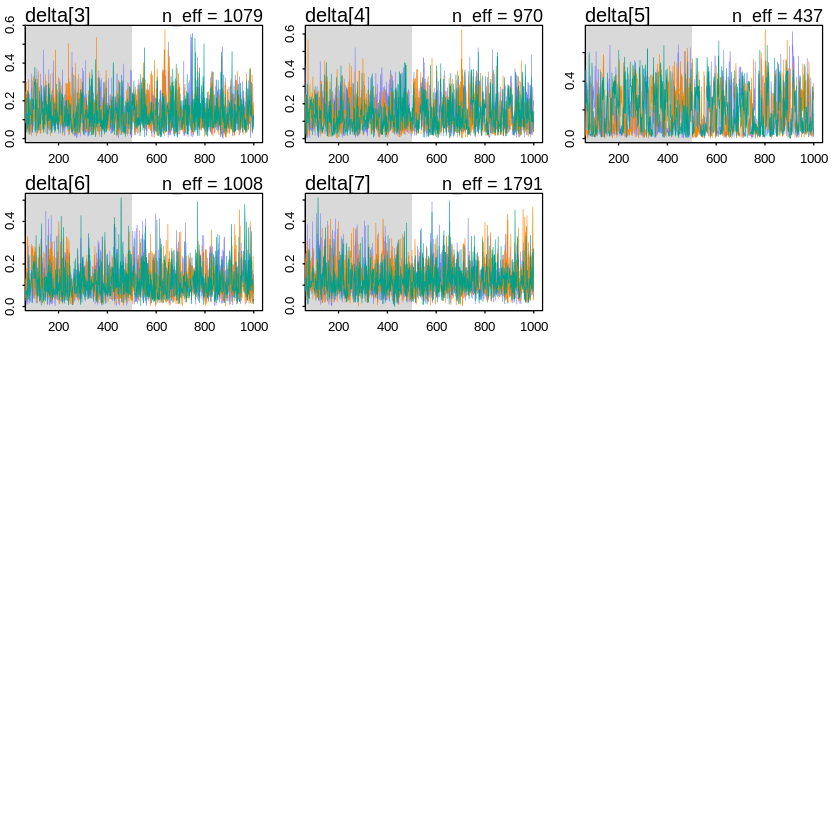

In [70]:
traceplot(m3)

The traceplots for m3 look OK, except for the kappas.